# Task 2: Flowers classification
Dmytro Geleshko

## Imports

In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

import seaborn as sns
from sklearn import metrics

## TF Config

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data
### Defining classes

In [4]:
classes = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

### Loading data

We can use tensorflow's fucntion to create image dataset from a directory, but for the sake of simplicity and ease of use with opencv, we will load it manually.

In [5]:
# array of labeled data: [x, y]
data = []

for i, c_name in enumerate(classes):
    count = 0
    path = "data/" + c_name
    for root, dir, files in os.walk(path):
        for file_name in files:
            if file_name.endswith(".jpg"):
                data.append([cv2.imread(path + "/" + file_name), i])
                count += 1
    print("Loaded", count, "images of", classes[i])

Loaded 518 images of daisy
Loaded 239 images of dandelion
Loaded 472 images of roses
Loaded 420 images of sunflowers
Loaded 602 images of tulips


### Preview examples of data

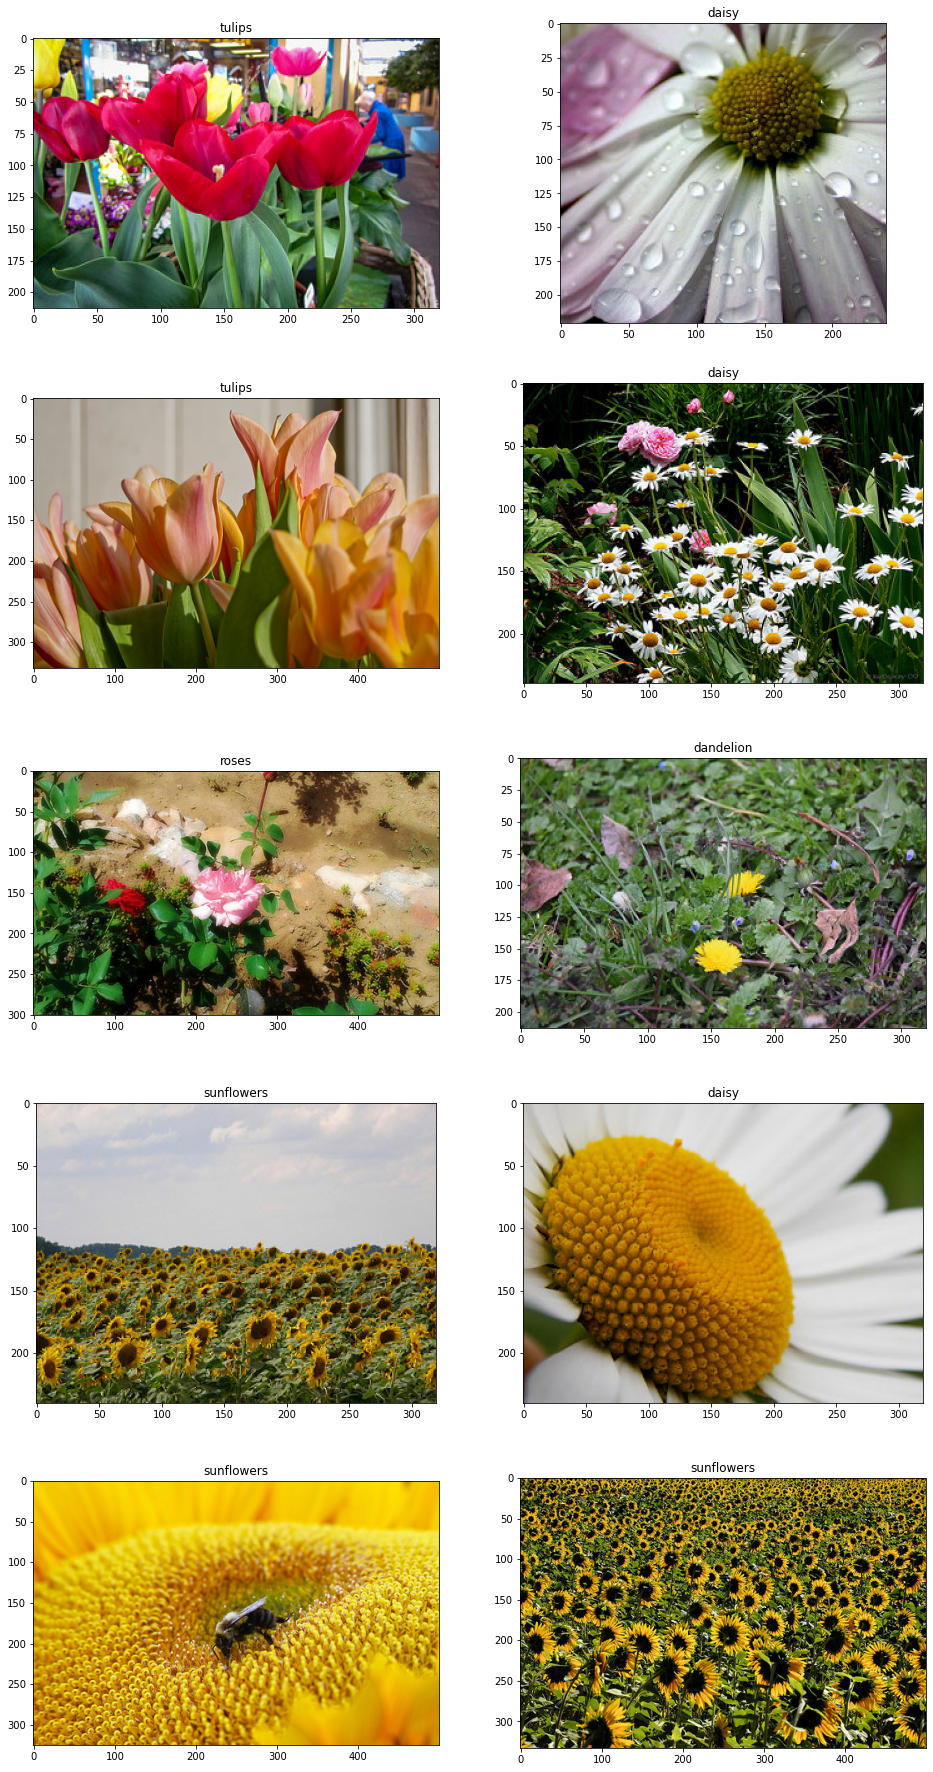

In [6]:
plt.rcParams["figure.figsize"] = (16, 32)

for i in range(10):
    rand_img = np.random.randint(0, len(data))
    plt.subplot(5, 2, i + 1)
    plt.imshow(data[rand_img][0][:,:,::-1])
    plt.title(classes[data[rand_img][1]])
plt.show()

### Image shapes

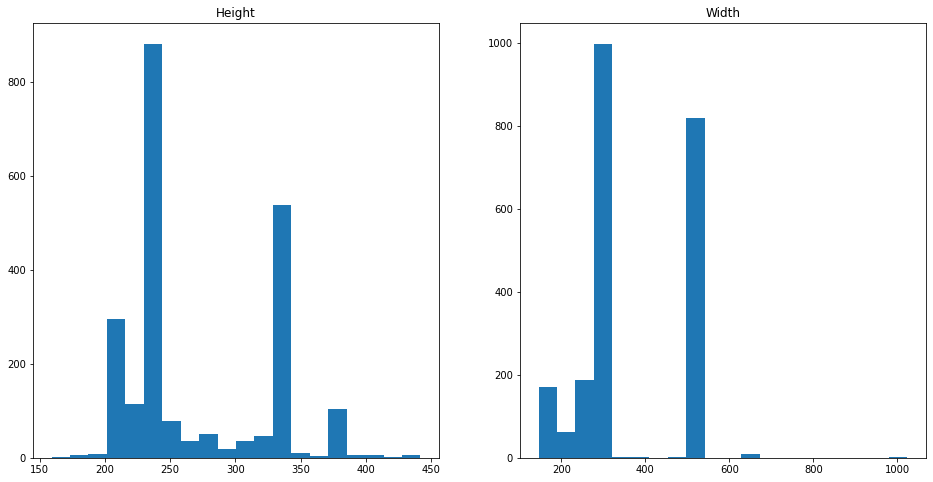

In [7]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.hist([x.shape[0] for x, _ in data], 20)
plt.title("Height")
plt.subplot(1, 2, 2)
plt.hist([x.shape[1] for x, _ in data], 20)
plt.title("Width")
plt.show()

Images have different resolution so we will have to resize/crop/pad them.

### Data Split

In [8]:
random.seed(10)
random.shuffle(data)

train = data[:int(len(data) * 0.7)]
dev = data[int(len(data) * 0.7): int(len(data) * 0.85)]
test = data[int(len(data) * 0.85):]

print("Train:", len(train))
print("Dev:", len(dev))
print("Test:", len(test))

Train: 1575
Dev: 338
Test: 338


## FC Neural Network
### Preprocessing
For our first (traditional) neural network we will try to extract features manually, because if we were to input the images directly, every neuron in the first layer would have a weight to every channel of every pixel and that will not be helpful.

Features:
- R/G/B Histograms
- Histogram of Oriented Gradients

In [9]:
vectorized_unsigned_gradient = np.vectorize(lambda x: x - 180 if x > 180 else x)

def extract_img_features(img, channel_hist_bins=64, hog_bins=9, p_size=8):
    # get hist of each channel
    b_hist, _ = np.histogram(img[:, :, 0], bins=channel_hist_bins)
    g_hist, _ = np.histogram(img[:, :, 1], bins=channel_hist_bins)
    r_hist, _ = np.histogram(img[:, :, 2], bins=channel_hist_bins)
    channel_hist = np.concatenate((b_hist, g_hist, r_hist), axis=0)
    channel_hist = channel_hist / channel_hist.max()

    # resize and cast for hog
    imgf = (tf.image.resize_with_crop_or_pad(img, 192, 192).numpy() / 255).astype(np.float32)

    # gx and gy
    gx = cv2.Sobel(imgf, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(imgf, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    # take max of mag along BGR channels
    max_mag_mask = np.argmax(mag, axis=2, keepdims=True)

    # apply the mask to both mag and angle matrix
    mag = np.take_along_axis(mag, max_mag_mask, axis=2).squeeze()
    angle = np.take_along_axis(angle, max_mag_mask, axis=2).squeeze()

    # "unsign" gradients
    vectorized_unsigned_gradient(angle)
    
    # init hog vector
    hog = np.zeros(shape=(imgf.shape[0] // p_size, imgf.shape[1] // p_size, hog_bins))
    for i in range(imgf.shape[0] // p_size):
        for j in range(imgf.shape[1] // p_size):
            # take a patch
            patch_angles = angle[i * p_size: (i + 1) * p_size, j * p_size: (j + 1) * p_size]
            patch_mag = mag[i * p_size: (i + 1) * p_size, j * p_size: (j + 1) * p_size]
            # calc hist
            hist, _ = np.histogram(patch_angles, bins=hog_bins, range=(0, 180), weights=patch_mag)
            # scale and save
            hog[i, j] = hist / (hist.max() + 1)
    hog = hog.flatten()
    return (np.concatenate((channel_hist, hog), axis=0)).astype(np.float32)

def nn_prepare_data(data, n_classes):
    x = np.array([extract_img_features(x, p_size=16) for x, y in data], dtype=np.float32)
    y = keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
    return x, y

In [10]:
train_x, train_y = nn_prepare_data(train, len(classes))
print("X:", train_x.shape, train_x.dtype)
print("Y:", train_y.shape, train_y.dtype)

X: (1575, 1488) float32
Y: (1575, 5) float32


In [11]:
dev_x, dev_y = nn_prepare_data(dev, len(classes))
print("X:", dev_x.shape, dev_x.dtype)
print("Y:", dev_y.shape, dev_y.dtype)

X: (338, 1488) float32
Y: (338, 5) float32


### Architecture

In [12]:
def build_nn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Dense(32)(X_in)
    X = layers.ReLU()(X)

    # dropout to reduce overfitting on some features
    X = layers.Dropout(0.2)(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [13]:
nn = build_nn((1488), len(classes))
print(nn.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1488)]            0         
                                                                 
 dense (Dense)               (None, 32)                47648     
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 re_lu_1 (ReLU)              (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 85    

In [14]:
nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [15]:
nn_hist_train = nn.fit(x=train_x, y=train_y, validation_data=(dev_x, dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 1s 8ms/step - loss: 1.5118 - categorical_accuracy: 0.3511 - val_loss: 1.3522 - val_categorical_accuracy: 0.4556
Epoch 2/25
50/50 [==============================] - 0s 4ms/step - loss: 1.3453 - categorical_accuracy: 0.4387 - val_loss: 1.1954 - val_categorical_accuracy: 0.5385
Epoch 3/25
50/50 [==============================] - 0s 3ms/step - loss: 1.2420 - categorical_accuracy: 0.5060 - val_loss: 1.1282 - val_categorical_accuracy: 0.5414
Epoch 4/25
50/50 [==============================] - 0s 4ms/step - loss: 1.1753 - categorical_accuracy: 0.5327 - val_loss: 1.1092 - val_categorical_accuracy: 0.5740
Epoch 5/25
50/50 [==============================] - 0s 4ms/step - loss: 1.0801 - categorical_accuracy: 0.5829 - val_loss: 1.0937 - val_categorical_accuracy: 0.5680
Epoch 6/25
50/50 [==============================] - 0s 5ms/step - loss: 1.0445 - categorical_accuracy: 0.5994 - val_loss: 1.0222 - val_categorical_accuracy: 0.6124
Epoch 7/25
50/50

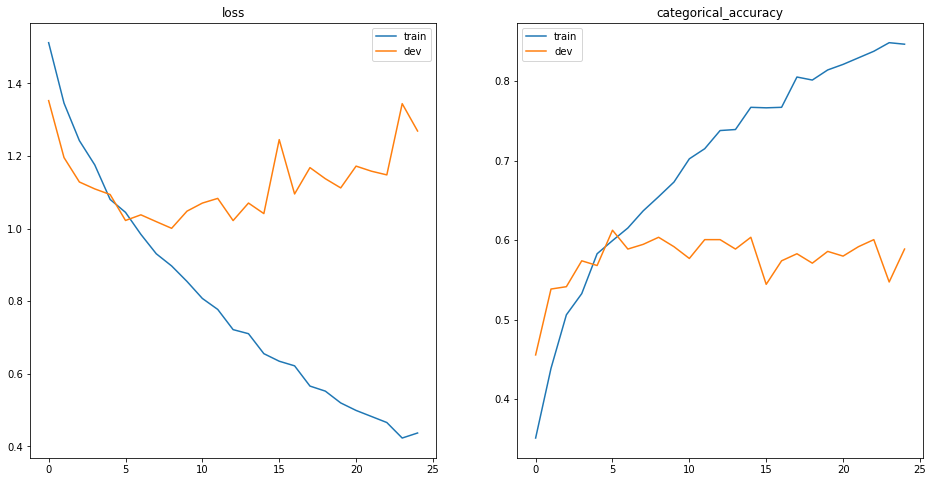

In [16]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(nn_hist_train.history["loss"], label="train")
plt.plot(nn_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(nn_hist_train.history["categorical_accuracy"], label="train")
plt.plot(nn_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

Even after manual feature extraction the model has a lot of trainable parameters which cause overfitting.

In [17]:
nn.save("models/nn")

INFO:tensorflow:Assets written to: models/nn\assets


## Convolutional Neural Network
Now lets try a more end-to-end approach by using a convolutional neural network. It's filters "stride" along the image and extract useful features.
### Preprocessing
Images themself will be resized to 192x192x3 using TensorFlow's and NumPy's methods

In [18]:
def cnn_prepare_data(data, h, w, n_classes):
    x = np.array([
        tf.image.resize_with_crop_or_pad((x / 255).astype(np.float32),
        target_height=h, target_width=w) for x, y in data], dtype=np.float32)

    y = keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
    return x, y

In [19]:
train_x, train_y = cnn_prepare_data(train, 192, 192, len(classes))
print("X:", train_x.shape, train_x.dtype)
print("Y:", train_y.shape, train_y.dtype)

X: (1575, 192, 192, 3) float32
Y: (1575, 5) float32


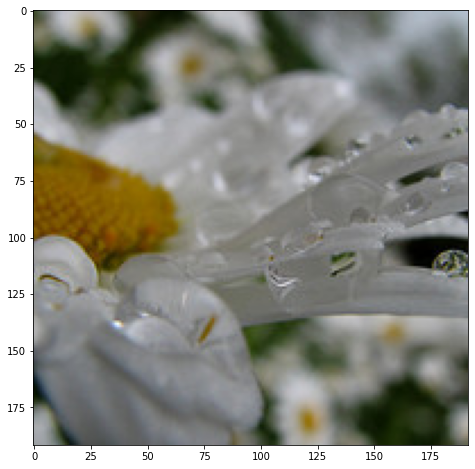

[1. 0. 0. 0. 0.]


In [20]:
example = 5
plt.imshow(train_x[example, :, :, ::-1])
plt.show()
print(train_y[example])

In [21]:
dev_x, dev_y = cnn_prepare_data(dev, 192, 192, len(classes))
print("X:", dev_x.shape, dev_x.dtype)
print("Y:", dev_y.shape, dev_y.dtype)

X: (338, 192, 192, 3) float32
Y: (338, 5) float32


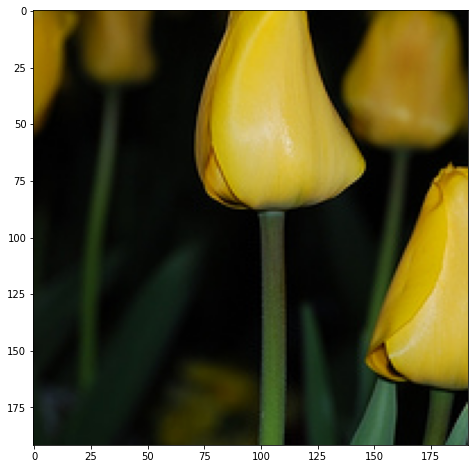

[0. 0. 0. 0. 1.]


In [22]:
example = 5
plt.imshow(dev_x[example, :, :, ::-1])
plt.show()
print(dev_y[example])

### CNN Architecture #1
This model will have more than half of the amount of trainable parameters.

In [23]:
def build_cnn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Conv2D(4, (3, 3), padding="same")(X_in)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(8, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(8, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(16, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(16, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(32, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Flatten()(X)

    X = layers.Dense(32)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [24]:
cnn = build_cnn((192, 192, 3), len(classes))
print(cnn.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 4)        0         
 )                                                               
                                                                 
 re_lu_2 (ReLU)              (None, 96, 96, 4)         0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 4)        16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 8)         296 

In [25]:
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [26]:
cnn_hist_train = cnn.fit(x=train_x, y=train_y, validation_data=(dev_x, dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 6s 57ms/step - loss: 1.4921 - categorical_accuracy: 0.3873 - val_loss: 1.5724 - val_categorical_accuracy: 0.2101
Epoch 2/25
50/50 [==============================] - 2s 38ms/step - loss: 1.0755 - categorical_accuracy: 0.5702 - val_loss: 1.5150 - val_categorical_accuracy: 0.2899
Epoch 3/25
50/50 [==============================] - 2s 41ms/step - loss: 0.9224 - categorical_accuracy: 0.6254 - val_loss: 1.5761 - val_categorical_accuracy: 0.2663
Epoch 4/25
50/50 [==============================] - 2s 38ms/step - loss: 0.7939 - categorical_accuracy: 0.6990 - val_loss: 1.4694 - val_categorical_accuracy: 0.4379
Epoch 5/25
50/50 [==============================] - 2s 38ms/step - loss: 0.6952 - categorical_accuracy: 0.7352 - val_loss: 1.3129 - val_categorical_accuracy: 0.3876
Epoch 6/25
50/50 [==============================] - 2s 40ms/step - loss: 0.6346 - categorical_accuracy: 0.7619 - val_loss: 1.2070 - val_categorical_accuracy: 0.4201
Epoch 7/25

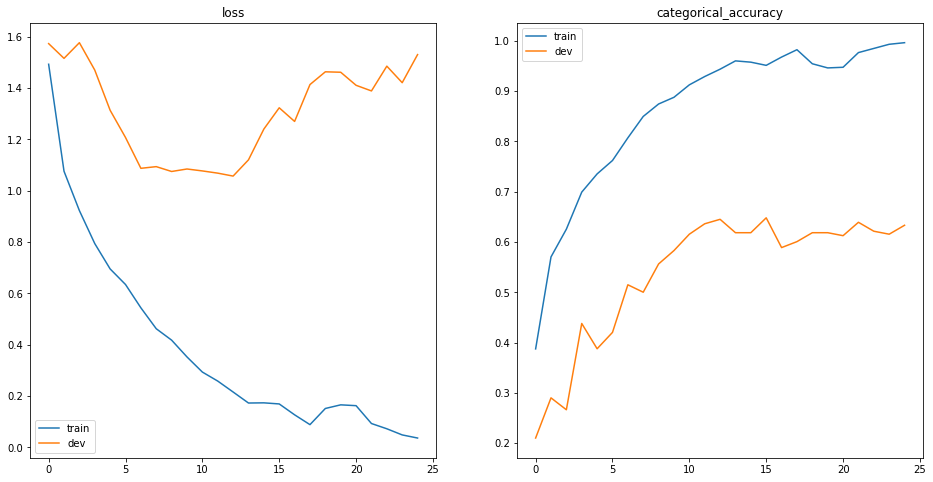

In [27]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn_hist_train.history["loss"], label="train")
plt.plot(cnn_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

Despite the fact that we have half the amount of trainable parameters, our model did better but overfitting is still the main issue.

In [28]:
cnn.save("models/cnn")

INFO:tensorflow:Assets written to: models/cnn\assets


### CNN Architecture #2: Inception-like
Same amount of parameters, different architecture

In [29]:
def inception_block(input, f1, k1, f2, k2, f3, k3):
    X21 = layers.Conv2D(f1, k1, padding="same")(input)
    X22 = layers.Conv2D(f2, k2, padding="same")(X21)

    X31 = layers.Conv2D(f1, k1, padding="same")(input)
    X32 = layers.Conv2D(f3, k3, padding="same")(X31)

    # concatanate them, MaxPool, ReLU, BatchNorm
    X = layers.concatenate([X22, X32])
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    # skip-connection, with MaxPool'ed input so that the dimentions are matched with the rest
    P = layers.MaxPool2D()(input)
    X = layers.concatenate([X, P])
    return X


def build_inception_cnn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = inception_block(
        X_in,
        3, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        3, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    X = inception_block(
        X,
        8, (1, 1),
        8, (3, 3),
        8, (5, 5))
    X = inception_block(
        X,
        8, (1, 1),
        8, (3, 3),
        8, (5, 5))
    
    X = layers.Flatten()(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [30]:
cnn2 = build_inception_cnn((192, 192, 3), len(classes))
print(cnn2.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 192, 192, 3)  12          ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 192, 192, 3)  12          ['input_3[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 192, 192, 2)  56          ['conv2d_6[0][0]']         

In [31]:
cnn2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [32]:
cnn2_hist_train = cnn2.fit(x=train_x, y=train_y, validation_data=(dev_x, dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 10s 129ms/step - loss: 1.4864 - categorical_accuracy: 0.4108 - val_loss: 1.4466 - val_categorical_accuracy: 0.4024
Epoch 2/25
50/50 [==============================] - 5s 99ms/step - loss: 1.0330 - categorical_accuracy: 0.5886 - val_loss: 1.4718 - val_categorical_accuracy: 0.4142
Epoch 3/25
50/50 [==============================] - 5s 97ms/step - loss: 0.8842 - categorical_accuracy: 0.6629 - val_loss: 1.5997 - val_categorical_accuracy: 0.4024
Epoch 4/25
50/50 [==============================] - 5s 95ms/step - loss: 0.7815 - categorical_accuracy: 0.7092 - val_loss: 1.3564 - val_categorical_accuracy: 0.4763
Epoch 5/25
50/50 [==============================] - 5s 103ms/step - loss: 0.7189 - categorical_accuracy: 0.7232 - val_loss: 1.1046 - val_categorical_accuracy: 0.5237
Epoch 6/25
50/50 [==============================] - 5s 99ms/step - loss: 0.6508 - categorical_accuracy: 0.7568 - val_loss: 0.9098 - val_categorical_accuracy: 0.6361
Epoch 7

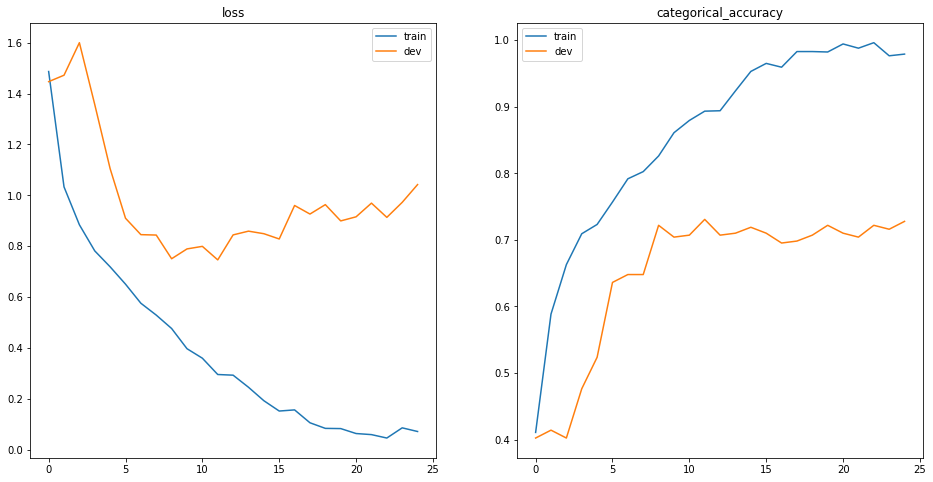

In [33]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn2_hist_train.history["loss"], label="train")
plt.plot(cnn2_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn2_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn2_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

Even better.

By using 1x1 convolution, applying filters with different kernel sizes and exploiting skip-connections we managed to reduce overfitting, but not a lot. Though there is one more thing we can do before stripping off even more trainable parameters.

In [34]:
cnn2.save("models/cnn2")

INFO:tensorflow:Assets written to: models/cnn2\assets


Much better but overfitting is still significant

## Data Augmentation
In this section we will try to create more training data by randomly applying some changes to train-set data, like:
- Random flip left-to-right
- Random rotation
- Random contrast

In [35]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.3),
  layers.RandomContrast(0.1)
])

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

def cnn_prepare_data_a(data, h, w, n_classes, batch_size=32, shuffle=False, augment=False):
  
  ds = tf.data.Dataset.from_tensor_slices((
    np.array([
        tf.image.resize_with_crop_or_pad((x / 255).astype(np.float32),
        target_height=h, target_width=w) for x, y in data], dtype=np.float32),

        keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
  ))

  if shuffle:
    ds = ds.shuffle(1000)

  # batch
  ds = ds.batch(batch_size)

  # train set augmentation
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [37]:
train_ds = cnn_prepare_data_a(train, 192, 192, len(classes), shuffle=True, augment=True)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [38]:
dev_ds = cnn_prepare_data_a(dev, 192, 192, len(classes))
dev_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

### CNN on Augmented Data
Lets re-train our previous model on this new augmented data

In [39]:
cnn3 = build_inception_cnn((192, 192, 3), len(classes))
print(cnn3.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 192, 192, 3)  12          ['input_4[0][0]']                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 192, 192, 3)  12          ['input_4[0][0]']                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 192, 192, 2)  56          ['conv2d_30[0][0]']        

In [40]:
cnn3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [41]:
cnn3_hist_train = cnn3.fit(train_ds, validation_data=dev_ds, epochs=25)

Epoch 1/25
50/50 [==============================] - 10s 146ms/step - loss: 1.4548 - categorical_accuracy: 0.4394 - val_loss: 1.4772 - val_categorical_accuracy: 0.3757
Epoch 2/25
50/50 [==============================] - 8s 142ms/step - loss: 1.0260 - categorical_accuracy: 0.5797 - val_loss: 1.4689 - val_categorical_accuracy: 0.2899
Epoch 3/25
50/50 [==============================] - 8s 137ms/step - loss: 0.9404 - categorical_accuracy: 0.6241 - val_loss: 1.4757 - val_categorical_accuracy: 0.2633
Epoch 4/25
50/50 [==============================] - 8s 139ms/step - loss: 0.8809 - categorical_accuracy: 0.6502 - val_loss: 1.3571 - val_categorical_accuracy: 0.3787
Epoch 5/25
50/50 [==============================] - 8s 140ms/step - loss: 0.8515 - categorical_accuracy: 0.6502 - val_loss: 1.1205 - val_categorical_accuracy: 0.4882
Epoch 6/25
50/50 [==============================] - 8s 139ms/step - loss: 0.8128 - categorical_accuracy: 0.6622 - val_loss: 1.1052 - val_categorical_accuracy: 0.4941
Epo

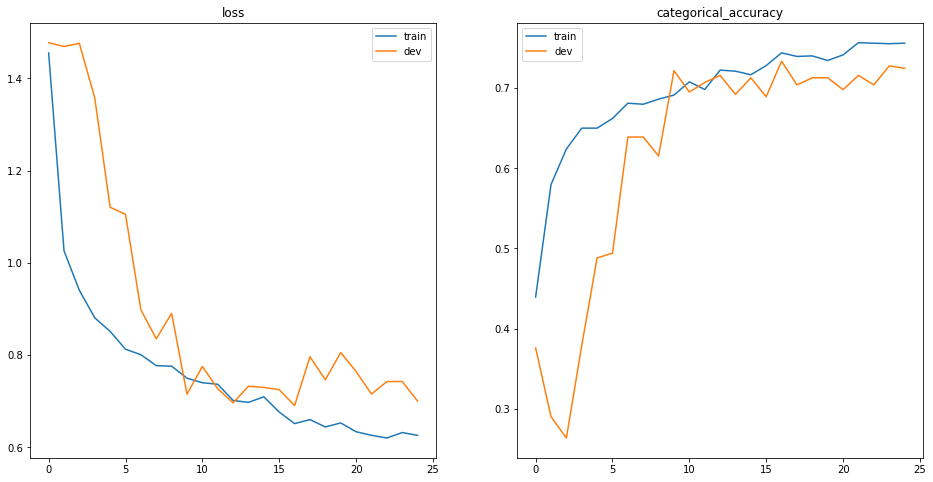

In [42]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn3_hist_train.history["loss"], label="train")
plt.plot(cnn3_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn3_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn3_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

Looks like we managed to prevent overfitting, and now we can even try to make our model more complex.

In [43]:
cnn3.save("models/cnn3")

INFO:tensorflow:Assets written to: models/cnn3\assets


### CNN Architecture #3: More complex

In [44]:
def build_inception_cnn_adv(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = inception_block(
        X_in,
        3, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    X = inception_block(
        X,
        8, (1, 1),
        8, (3, 3),
        8, (5, 5))
    X = inception_block(
        X,
        8, (1, 1),
        8, (3, 3),
        8, (5, 5))
    X = inception_block(
        X,
        16, (1, 1),
        16, (3, 3),
        16, (5, 5))

    X = layers.Flatten()(X)

    X = layers.Dense(64)(X)
    X = layers.ReLU()(X)
    X = layers.Dropout(0.2)(X)
    
    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [45]:
cnn4 = build_inception_cnn_adv((192, 192, 3), len(classes))
print(cnn4.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 192, 192, 3)  12          ['input_5[0][0]']                
                                                                                                  
 conv2d_56 (Conv2D)             (None, 192, 192, 3)  12          ['input_5[0][0]']                
                                                                                                  
 conv2d_55 (Conv2D)             (None, 192, 192, 2)  56          ['conv2d_54[0][0]']        

In [46]:
cnn4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [47]:
cnn4_hist_train = cnn4.fit(train_ds, validation_data=dev_ds, epochs=25)

Epoch 1/25
50/50 [==============================] - 11s 158ms/step - loss: 1.6432 - categorical_accuracy: 0.4216 - val_loss: 1.3816 - val_categorical_accuracy: 0.4142
Epoch 2/25
50/50 [==============================] - 8s 145ms/step - loss: 1.1290 - categorical_accuracy: 0.5492 - val_loss: 1.3898 - val_categorical_accuracy: 0.3166
Epoch 3/25
50/50 [==============================] - 9s 156ms/step - loss: 1.0126 - categorical_accuracy: 0.5898 - val_loss: 1.2264 - val_categorical_accuracy: 0.5118
Epoch 4/25
50/50 [==============================] - 8s 152ms/step - loss: 0.9506 - categorical_accuracy: 0.6190 - val_loss: 1.0809 - val_categorical_accuracy: 0.5769
Epoch 5/25
50/50 [==============================] - 8s 151ms/step - loss: 0.8626 - categorical_accuracy: 0.6502 - val_loss: 1.0046 - val_categorical_accuracy: 0.6272
Epoch 6/25
50/50 [==============================] - 8s 146ms/step - loss: 0.8441 - categorical_accuracy: 0.6362 - val_loss: 0.9813 - val_categorical_accuracy: 0.6361
Epo

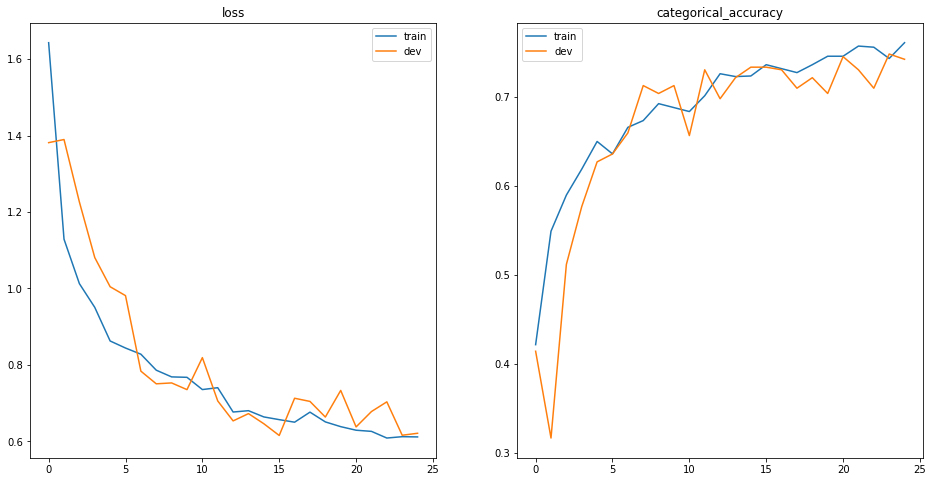

In [48]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn4_hist_train.history["loss"], label="train")
plt.plot(cnn4_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn4_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn4_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

This one has three times the amount of trainable parameters, but the performance gain is little. If so this might mean that we reached the limit using available data. Its time to test our model, and see what is up.

In [49]:
cnn4.save("models/cnn4")

INFO:tensorflow:Assets written to: models/cnn4\assets


## Testing

### Loading the best model

In [51]:
selected_model = tf.keras.models.load_model("models/cnn4")
selected_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 192, 192, 3)  12          ['input_5[0][0]']                
                                                                                                  
 conv2d_56 (Conv2D)             (None, 192, 192, 3)  12          ['input_5[0][0]']                
                                                                                                  
 conv2d_55 (Conv2D)             (None, 192, 192, 2)  56          ['conv2d_54[0][0]']        

### Test data

In [52]:
test_ds = cnn_prepare_data_a(test, 192, 192, len(classes))
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

### Predicting

In [53]:
selected_model.evaluate(test_ds)

11/11 [==============================] - 1s 43ms/step - loss: 0.7212 - categorical_accuracy: 0.7189


[0.7212021946907043, 0.7189348936080933]

### Metrics
Lets look at more sophisticated metrics

In [58]:
y = keras.utils.to_categorical([y for _, y in test], num_classes=len(classes), dtype=np.float32)

y_hat = selected_model.predict(test_ds)

Convert Y's one-hot and Yhat's probability representations to labels

In [75]:
y_labels = np.argmax(y, axis=1)
y_hat_labels = np.argmax(y_hat, axis=1)
y_labels[::10], y_hat_labels[::10]

(array([0, 4, 4, 4, 4, 1, 2, 4, 0, 0, 1, 4, 1, 4, 2, 4, 3, 2, 2, 4, 3, 0,
        1, 0, 4, 3, 1, 1, 0, 3, 2, 3, 4, 2], dtype=int64),
 array([0, 4, 4, 4, 4, 1, 4, 4, 0, 0, 1, 4, 1, 4, 0, 4, 3, 2, 0, 2, 3, 0,
        1, 0, 4, 3, 1, 1, 0, 3, 2, 3, 2, 2], dtype=int64))

In [90]:
print(metrics.classification_report(y_labels, y_hat_labels, target_names=classes))

              precision    recall  f1-score   support

       daisy       0.71      0.85      0.78        61
   dandelion       0.78      0.53      0.63        34
       roses       0.57      0.64      0.60        69
  sunflowers       0.73      0.92      0.81        62
      tulips       0.83      0.64      0.72       112

    accuracy                           0.72       338
   macro avg       0.72      0.72      0.71       338
weighted avg       0.73      0.72      0.72       338



Because it isn't a dataset with imbalanced classes, the scores are close to categorical_accuracy.

Yet there are some interesting information like: 
- dandelion 0.53 recall, meaning out of all dandelions only 53% are classified as such.
- roses 0.57 precision, meaning out of all flowers, classified as roses only 57% are actually roses.

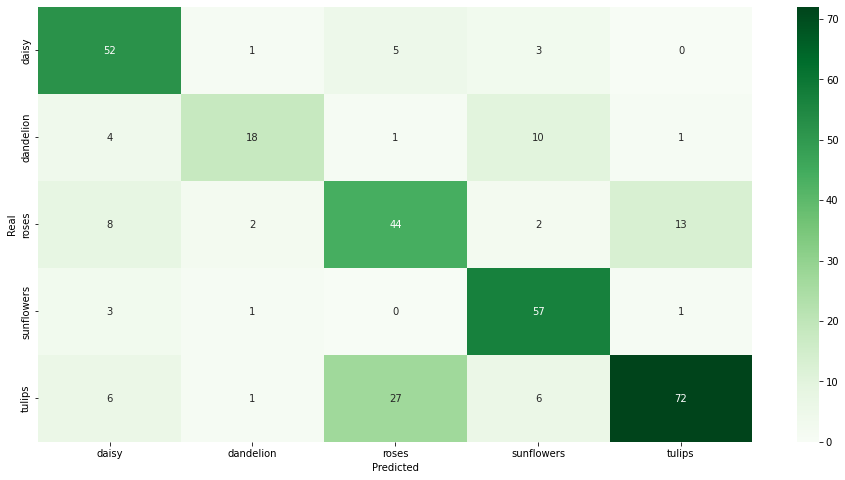

In [95]:
sns.heatmap(metrics.confusion_matrix(y_labels, y_hat_labels), cmap="Greens", annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

The most obvious problem is the misclassification of tulips as roses and the other way around (explains low roses precision we saw earlier).

There's also some dandelions which were classified as sunflowers (explains low dandelions recall).

### TODO:
- analyze misclassified images (maybe bad img quality, mislabeled, weather, other objects ... etc)
- collect more data
- tweaking loss function for problematic classes

## Inference example

### Loading the model

In [2]:
selected_model = tf.keras.models.load_model("models/cnn4")

### Loading the data
I copied some photos from "data/daisy" folder to "infer" folder

In [8]:
def load_infer_data(infer_path):
    infer_data = []
    for root, dir, files in os.walk(infer_path):
            for file_name in files:
                if file_name.endswith(".jpg"):
                    infer_data.append(cv2.imread(infer_path + "/" + file_name))

    return np.array([tf.image.resize_with_crop_or_pad(img, 192, 192) / 255 for img in infer_data], dtype=np.float32)

In [9]:
infer_ds = load_infer_data("infer")
infer_ds.shape

(6, 192, 192, 3)

### Predicting

In [13]:
labels = np.argmax(selected_model.predict(infer_ds), axis=1)
labels

array([0, 2, 0, 0, 0, 2], dtype=int64)

## The End